#  Gaussian Naive Bayes


[Gaussian Naive Bayes](http://i.stanford.edu/pub/cstr/reports/cs/tr/79/773/CS-TR-79-773.pdf)

高斯模型假设数据每一维特征都服从高斯分布.


${\displaystyle P(x|y)={1 \over \sigma {\sqrt {2\pi }}}\,e^{-{(x-\mu )^{2} \over 2\sigma ^{2}}}} $

所以我们只需要求得每一个特征的$\sigma_i,\mu_i$在使用每一个特征的$\sigma_i,\mu_i$,去计算高斯值,即可以得到条件概率.




In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from scipy.stats import multivariate_normal

#### 1 加载数据集

In [2]:
def create_data():
    iris = load_iris()
    df = pd.DataFrame(iris.data, columns=iris.feature_names)
    df['label'] = iris.target
    df.columns = ['sepal length', 'sepal width', 'petal length', 'petal width', 'label']
    data = np.array(df.iloc[:100, [0, 1, -1]])
    return data[:,:2], data[:,-1]

In [3]:
X, y = create_data()

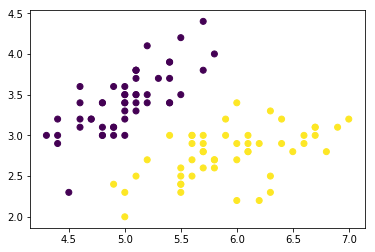

In [4]:
plt.scatter(X[:,0],X[:,1],c=y)

#### 1.1 将原始数据集划分为训练样本和测试样本

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
X_train[:4]

array([[5.7, 2.8],
       [5.6, 3. ],
       [5. , 3.4],
       [4.4, 3.2]])

#### 2 模型搭建

那么我们该如何使用Gaussian Naive Bayes去预测数据的类型呢?

**Gaussian Naive Bayes algorithm:**

输入:样本$X=\{x_1,x_2,...,x_m\}$,每个样本$x_i$有$n$个特征,标签$Y=\{y_1,y_2,...,y_n\}$,每一个标签$y_i$有$K=\{k_1,k_2,...,k_z\}$个类别可选.

输出:测试样本的预测标签

(1) 对于训练样本计算不同$k_i$类下的均值和方差$\mu,\sigma$并计算先验概率$P(Y=k)$

(2) 将测试样本与不同$k_i$下的均值和方差$\mu_k,\sigma_k$求高斯概率$G_k$.

(3) 将计算出来的$G_k$乘上先验概率$P(Y=k)$则可以得到不同$k$类下的后验概率$P(Y_k|X)$

**Ps:**

(1) 每个样本$x_i$有$n$个特征,GNB将每个特征看成是独立的一维高斯分布,所以$n$个特征有$n$个$\mu,\sigma$,记为$\mu=\{\mu_1,...,\mu_n\},\Sigma=\{\sigma_1,...,\sigma_n\}$,另外有$K$类标签,即会有$K$个$\mu,\sigma$组.所以参数$\mu,\sigma$的形状是(K,n)

(2) 在不同$K$标签下的数据求的$K$个参数组,即可以得到条件概率$P(X|Y=k)$

(3) 有$K$类标签,所以先验概率($P(Y)$)的形状是(K,).

### 2.1 Example

我们取鸢尾花的某几个样本来举例.

假设:$X=\begin{bmatrix}
5.7 &2.8 \\ 
 5.6&3. \\ 
 5.&3.4 \\ 
 4.4&3.2 
\end{bmatrix}$,$Y=\begin{bmatrix}
0 &1  &0  &1 
\end{bmatrix}$

每组样本有两个特征,比如第一组样本(5.7,2.8).有2类,分别是0,1

计算样本$X$的高斯参数和先验概率:


在$k=0$下:

$\mu_0 = [\frac{5.7+5}{2},\frac{2.8+3.4}{2}] =[\mu_{00},\mu_{01}]= [5.35,3.1]$

$\sigma_0 = [\frac{(5.7 - 5.35)^{2} + (5.5 - 5.35)^{2}}{2-1},\frac{(2.8-3.1)^{2}+(3.4-3.1)^{2}}{2-1}]=[\sigma_{00},\sigma_{01}]= [0.145,0.18]$

$P(Y=0)=0.5$

同样在$k=1$下(就是上面的意思随便写下数字):

$\mu_1=[\mu_{10},\mu_{11}]=[4.4,3.2]$

$\sigma_1=[\sigma_{10},\sigma_{11}]=[0.115,0.225]$

$P(Y=1)=0.5$

所以

$\mu=\begin{bmatrix}
\mu_0\\ \mu_1 
\end{bmatrix}=\begin{bmatrix}
5.35 &3.1 \\ 
 4.4&3.2 
\end{bmatrix}$

$\sigma=\begin{bmatrix}
\sigma_0\\ \sigma_1 
\end{bmatrix}=\begin{bmatrix}
0.145 &0.18 \\ 
 0.115&0.225 
\end{bmatrix}$

$P(Y)=[0.5,0.5]$

假设现在的测试样本为$Z=[1,2]$,则:

条件概率:

$P(Z|Y=0)=P(z_1|Y=0)P(z_2|Y=0)=N(z_1,\mu_{00},\sigma_{00})\cdot N(z_2,\mu_{01},\sigma_{01})$

$P(Z|Y=1)=P(z_1|Y=1)P(z_2|Y=1)=N(z_1,\mu_{10},\sigma_{10})\cdot N(z_2,\mu_{11},\sigma_{11})$



后验概率:

$P(Y=0|Z)$=$P(Z|Y=0)\cdot P(Y=0)$

$P(Y=1|Z)$=$P(Z|Y=1)\cdot P(Y=1)$

那么那个后验概率即为$Z$的标签

### 3 Build GNB

In [7]:
def NaiveBayes_Gaussian(X_train,y_train):
    """
    Build Gaussian Naive Bayes
    
    Parameters:
    ----------
       X_train: training set.
       y_train: training labels.
       
    Return:
    ------
        pri_prob:Priori probability
        mu: Gaussian parameter.
        sigma: Gaussian parameter.
        
    """
    
    m,n = X_train.shape
    unique_y = np.unique(y_train)
    K = unique_y.shape[0] # get K classify.
    
    # initialization parameters.
    mu = np.zeros((K,n))
    sigma = np.zeros((K,n))
    pri_prob = np.zeros(K)
    
    for k in range(K):
        y = np.where(y_train==unique_y[k])[0]
        pri_prob[k] = y.shape[0] / m # compute pri prob
        mu[k] = np.mean(X_train[y],axis=0) # compute average
        sigma[k] = np.var(X_train[y],axis=0) # comepute var
        
        
    return pri_prob,mu,sigma

In [8]:
pri_prob,mu,sigma = NaiveBayes_Gaussian(X_train,y_train)

得到了训练样本的高斯参数了之后,我们可以使用测试样本去预测样本标签.

### 3.1 testing model.

在计算高斯值的时候我们可以使用scipy库中的[multivariate_normal.pdf](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.multivariate_normal.html)以便于快速计算,当然手写高斯公式也是非常简单的.

multivariate_normal.pdf:能计算多元高斯分布,也能计算1D高斯分布,当你给予的协方差是一个对称矩阵的时候,它将计算多元高斯分布,如果给予的是一组实数(方差)且与样本的特征数大小相同,那么会将其变为对角阵,就等同于[多个1D高斯连乘即](https://www.datalearner.com/blog/1051485590815771):

```python
a = multivariate_normal.pdf(X_test[0],mean=mu[0],cov=sigma[0]) 
b = multivariate_normal.pdf(X_test[0][0],mean=mu[0][0],cov=sigma[0][0]) 
c = multivariate_normal.pdf(X_test[0][1],mean=mu[0][1],cov=sigma[0][1])
a = c * b # 保留12小数点内
```

下面这段代码:

```python
prob = multivariate_normal.pdf(X_test,mean=mu[k],cov=sigma[k]) * pri_prob[k]```

先用Numpy的广播机制,将mu,sigma广播为与X_test的形状相同,同时计算m个样本

**Ps:**

(1) 这里的sigma[0]实际上是一个类似于[a,b]的形式,那么multivariate_normal会将其扩展为对角阵的形式$\begin{bmatrix}
a &0 \\ 
 0& b
\end{bmatrix}$.

(2)当协方差矩阵是对角阵的时候,多元高斯分布就是一组相互独立的一元高斯分布的乘积(组合).这与我们的设想是一样,因为在Naive Bayes的条件是**特征独立**.

In [26]:
def predict(pri_prob,mu,sigma,X_test):
    """
    Implementation predict of GNB.
    
    Prameters:
    ----------
        pri_prob:priori proba
        mu: Gaussian parameter
        sigma:Gaussian parameter
        X_test: testing set
        
    Return:
    ------
        np.argmax(pridict,axis=1): predict labels
    """
    m,n = X_test.shape
    pridict = np.zeros((m,n))
    
    for k in range(n):
        prob = multivariate_normal.pdf(X_test,mean=mu[k],cov=sigma[k]) * pri_prob[k]
        
        pridict[:,k] = prob
        
    return np.argmax(pridict,axis=1)

In [27]:
predict_label = predict(pri_prob=pri_prob,mu=mu,sigma=sigma,X_test=X_test)
print("predict labels is: ",predict_label)

predict labels is:  [1 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 1 0 0]


得到了预测的标签,我们可以去检测正确率

### 3.2 score of GNB

```python
np.sum(predict_y == y_test)```

这段代码表示数组predict与y_test值相同则会返回True.

那么在Python中True则代表1,求和后除上总个数就是正确率

In [11]:
def score(pri_prob,mu,sigma,X_test,y_test):
    predict_y = predict(pri_prob,mu,sigma,X_test)
    Correct_rate = np.sum(predict_y == y_test) / y_test.shape[0]
    print("correct rate is :{}".format(Correct_rate))

In [12]:
score(pri_prob,mu,sigma,X_test,y_test)

correct rate is :1.0


### scikit:GaussianNB:

也可以使用scikit-learn中的[GaussianNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB)来分类数据

In [13]:
from sklearn.naive_bayes import GaussianNB

In [14]:
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

In [15]:
gnb.score(X_test,y_test)

1.0

可以看到自写的NaiveBayes_Gaussian函数预测的结果是和scikit一样,说明过程正确.